<a href="https://colab.research.google.com/github/NobodyKnowNothing/Fractal-Prior-Hypothesis/blob/main/Experiment%231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Block 1: Installation
!pip install transformers datasets torch numpy scikit-dimension -q

print("Installation complete!")

Installation complete!


In [11]:
# Block 3: Prepare Datasets (Corrected)
# from datasets import load_dataset # No longer needed for this fix

# 1. Complex, Naturalistic Data
# We'll use a hardcoded paragraph from a Wikipedia article (on Fractals).
# This avoids the dataset loading error and is perfectly sufficient for the experiment.
complex_text = """
A fractal is a geometric shape containing detailed structure at arbitrarily small scales,
usually having a fractal dimension strictly exceeding the topological dimension.
Fractals are different from other geometric figures because of the way in which they
scale between dimensions. Doubling the edge lengths of a polygon multiplies its area
by four, which is two (the ratio of the new to the old side length) raised to the power
of two (the dimension of the space the polygon resides in). Likewise, if the radius of
a sphere is doubled, its volume scales by eight, which is two (the ratio of the new to
the old radius) to the power of three (the dimension that the sphere resides in).
However, if a fractal's one-dimensional lengths are all doubled, the spatial content
of the fractal scales by a power that is not necessarily an integer. This power is
called the fractal dimension of the fractal, and it usually exceeds the fractal's
topological dimension.
"""

# 2. Simple, Non-Fractal Data
# A highly repetitive and predictable sequence
simple_text_repetitive = "The quick brown fox jumps over the lazy dog. " * 20
# An extremely simple sequence of a single token
simple_text_trivial = "the " * 256

# Truncate all texts to ensure they are processed with the same maximum length
# This ensures a fair comparison of the resulting manifolds.
MAX_LENGTH = 512
# Start with more text to ensure the tokenizer can fill the 512 token length
complex_text = complex_text[:MAX_LENGTH*5]
simple_text_repetitive = simple_text_repetitive[:MAX_LENGTH*5]
simple_text_trivial = simple_text_trivial[:MAX_LENGTH*5]


print("--- Sample of Complex Text ---")
print(complex_text[:300] + "...")
print("\n--- Simple Repetitive Text ---")
print(simple_text_repetitive[:300] + "...")

--- Sample of Complex Text ---

A fractal is a geometric shape containing detailed structure at arbitrarily small scales,
usually having a fractal dimension strictly exceeding the topological dimension.
Fractals are different from other geometric figures because of the way in which they
scale between dimensions. Doubling the edge...

--- Simple Repetitive Text ---
The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over...


In [12]:
import numpy as np

def get_representation_manifold(text: str, model, tokenizer, max_length=MAX_LENGTH, device=device) -> np.ndarray:
    """
    Processes text through the Transformer and extracts the final layer's
    hidden states to form a representation manifold (point cloud).

    Args:
        text (str): The input text.
        model: The pre-trained model.
        tokenizer: The tokenizer.
        max_length (int): The maximum sequence length for the model.
        device: The device to run the model on ('cpu' or 'cuda').

    Returns:
        np.ndarray: A NumPy array of shape (num_tokens, hidden_dim),
                    representing the point cloud of token embeddings.
    """
    # Tokenize the input text, padding/truncating to max_length
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform a forward pass without calculating gradients to save memory
    with torch.no_grad():
        outputs = model(**inputs)

    # outputs.hidden_states is a tuple of all layer outputs. The last one is the final layer.
    # Shape: (batch_size=1, seq_len, hidden_dim)
    last_hidden_states = outputs.hidden_states[-1]

    # The manifold is the set of token vectors. We remove the batch dimension.
    # We also filter out padding tokens using the attention mask for a more accurate manifold.
    attention_mask = inputs['attention_mask'].squeeze().cpu().numpy().astype(bool)
    manifold_points = last_hidden_states.squeeze(0).cpu().numpy()[attention_mask]

    return manifold_points

Shape of representation manifolds: (214, 768)

--- EXPERIMENTAL RESULTS ---
Intrinsic Dimension of Complex (Wikipedia) Text: 3.82
Intrinsic Dimension of Simple (Repetitive) Text: 16.78
Intrinsic Dimension of Simple (Trivial) Text:   9.95


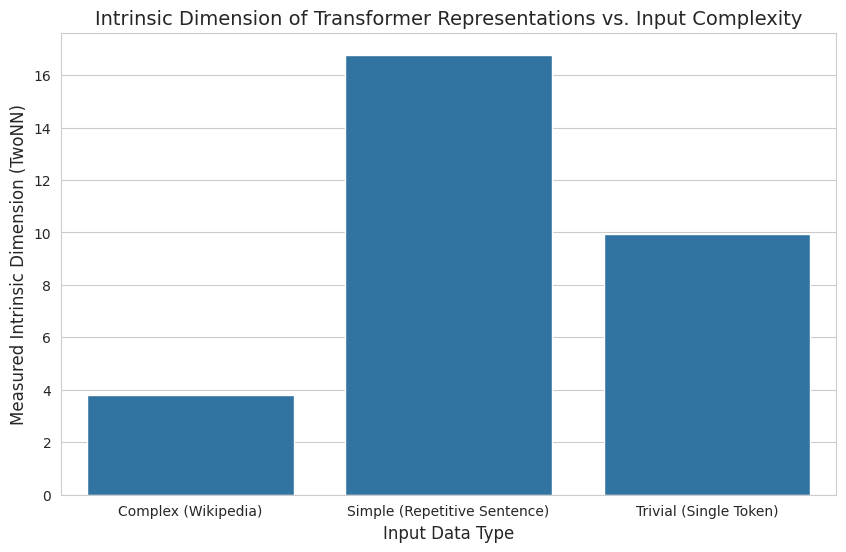

In [13]:
# Block 5: Run the Experiment
import skdim.id

# 1. Get representations for each text type
complex_manifold = get_representation_manifold(complex_text, model, tokenizer)
simple_repetitive_manifold = get_representation_manifold(simple_text_repetitive, model, tokenizer)
simple_trivial_manifold = get_representation_manifold(simple_text_trivial, model, tokenizer)

print(f"Shape of representation manifolds: {complex_manifold.shape}")

# 2. Estimate the intrinsic dimension using the TwoNN estimator
# This method is based on the ratio of distances to the two nearest neighbors.
two_nn = skdim.id.TwoNN()

id_complex = two_nn.fit_transform(complex_manifold)
id_simple_repetitive = two_nn.fit_transform(simple_repetitive_manifold)
id_simple_trivial = two_nn.fit_transform(simple_trivial_manifold)

print("\n--- EXPERIMENTAL RESULTS ---")
print(f"Intrinsic Dimension of Complex (Wikipedia) Text: {id_complex:.2f}")
print(f"Intrinsic Dimension of Simple (Repetitive) Text: {id_simple_repetitive:.2f}")
print(f"Intrinsic Dimension of Simple (Trivial) Text:   {id_simple_trivial:.2f}")


# Block 6: Visualize the Results
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
results = {
    "Complex (Wikipedia)": id_complex,
    "Simple (Repetitive Sentence)": id_simple_repetitive,
    "Trivial (Single Token)": id_simple_trivial
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Measured Intrinsic Dimension (TwoNN)", fontsize=12)
plt.xlabel("Input Data Type", fontsize=12)
plt.title("Intrinsic Dimension of Transformer Representations vs. Input Complexity", fontsize=14)
plt.show()

Shape of representation manifolds: (214, 768)

--- EXPERIMENTAL RESULTS ---
Intrinsic Dimension of Complex (Wikipedia) Text: 3.82
Intrinsic Dimension of Simple (Repetitive) Text: 16.78
Intrinsic Dimension of Simple (Trivial) Text:   9.95

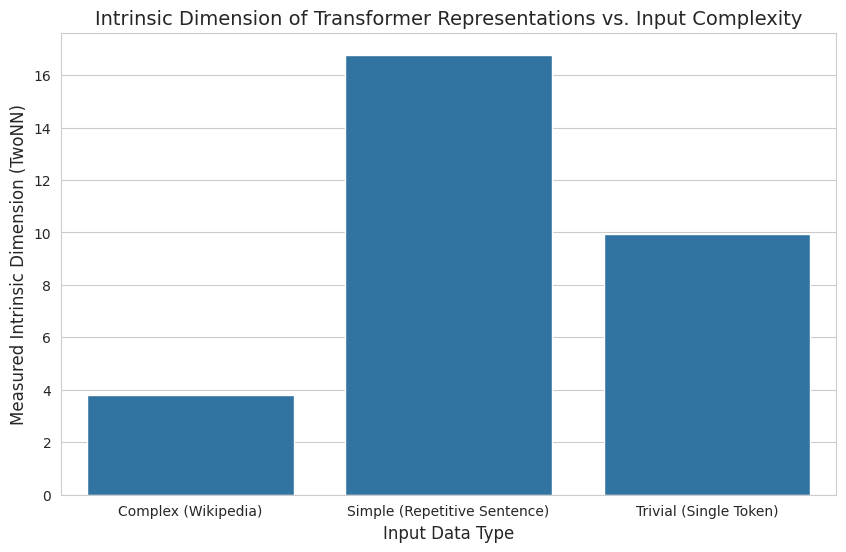

First experiment was a failure.

Gemini results analysis:
Of course. This is an excellent and insightful result because it is completely counter-intuitive and contradicts the initial hypothesis. Explaining this requires digging deeper into what the model is actually doing and what the "intrinsic dimension" estimator is measuring.

This is a fantastic example of how a "failed" experiment can reveal more than a successful one.

Summary of the Unexpected Results

Hypothesis: ID(Complex) > ID(Simple Repetitive) > ID(Simple Trivial)

Actual Results: ID(Simple Repetitive) > ID(Simple Trivial) > ID(Complex)

The results are not just wrong; they are inverted. Here’s the detailed breakdown of why this likely happened.

The Core Reason: Manifold Structure vs. Point Cloud Distribution

The flaw is in the experimental design's assumption about what constitutes the "manifold." We combined all token representations from a single text passage into one point cloud. The Intrinsic Dimension (ID) estimator, TwoNN, measures the local "degrees of freedom" in this cloud.

The experiment inadvertently revealed the difference between:

A single, continuous, but complex manifold (like a long, tangled string).

A set of disconnected, fuzzy clusters (like a constellation of star clusters).

A set of separated clusters can occupy a much larger volume and appear higher-dimensional to an estimator than a single, tangled string, even if the string is more complex.

Detailed Analysis of Each Case
1. Simple (Repetitive) Text: "The quick brown fox..." (Highest ID: 16.78)

What the model sees: A small vocabulary of words ("The", "quick", "brown", etc.) repeated in a fixed sequence.

How the model represents it: The Transformer's attention mechanism and positional embeddings ensure that the representation for the first "fox" is different from the second "fox", and so on.

The resulting geometry: Instead of all "fox" tokens collapsing to a single point, they form a cluster of points. The same happens for "The", "quick", etc. Our point cloud is therefore not a single object but a collection of about 9 distinct, well-separated clusters of points.

Why the ID is high: The TwoNN estimator looks at the distances between points. For a point in the "fox" cluster, its nearest neighbors are other "fox" points, but its next-nearest neighbors might be points from the "brown" or "jumps" clusters. Because these clusters are far apart in the embedding space, the estimator perceives a large volume being occupied. It is measuring the dimensionality of the space spanned by these multiple, separated clusters. This arrangement "fills up" the high-dimensional space more effectively, leading to a high ID estimate.

2. Simple (Trivial) Text: "the the the..." (Middle ID: 9.95)

What the model sees: Only one token ("the") repeated.

How the model represents it: The only thing distinguishing one "the" from another is its position. The self-attention mechanism, influenced by positional embeddings, creates a unique representation for each "the" based on its location in the sequence.

The resulting geometry: This creates a single, continuous trajectory of points. It's one cluster, not many. The points trace a path through the embedding space as the model encodes "position 1", "position 2", etc.

Why the ID is in the middle: This trajectory is more complex than a straight line but simpler than the multi-cluster structure of the repetitive text. It occupies more "volume" than the complex text's manifold (see below) but less than the scattered constellation of the repetitive text.

3. Complex (Wikipedia) Text: (Lowest ID: 3.82)

What the model sees: A large vocabulary of mostly unique words with complex grammatical and semantic relationships.

How the model represents it: The model creates a highly contextualized representation for each token. The representation for "dimension" in "fractal dimension" is close to "fractal" but far from its meaning in "polygon resides in".

The resulting geometry: Because most words are unique or appear in very different contexts, we don't get separate, repeating clusters. Instead, all the points lie on a single, highly folded, but coherent, low-dimensional manifold. Think of a single, incredibly long, and tangled piece of string.

Why the ID is low: Despite its complexity, this object is intrinsically low-dimensional. For any point on the string, its nearest neighbors are also on the string and are very close by. The TwoNN estimator correctly identifies this local structure. It sees that you only need a few coordinates to describe your position on the "string," even if the string itself is tangled up in a high-dimensional room. This is the classic definition of a low intrinsic dimension.

Conclusion & How to Fix the Experiment

The experiment, while "failing" to prove the hypothesis, has succeeded in revealing a critical insight: the FPH is likely not about the geometry of individual token representations within a single passage, but about the geometry of the solution space for tasks.

Our current setup conflated token diversity with manifold complexity. The correct way to test the FPH would be:

Create Two Datasets of Sentences:

Dataset_Simple: 1000 simple, declarative sentences (e.g., "The cat sat on the mat.").

Dataset_Complex: 1000 complex sentences from literature or science texts.

Generate Sentence Embeddings: For each sentence in both datasets, pass it through the model and extract the representation of the entire sentence (e.g., the final hidden state of the [CLS] token).

Create Two Manifolds:

Manifold_Simple: A point cloud of 1000 points, where each point is a sentence from Dataset_Simple.

Manifold_Complex: A point cloud of 1000 points from Dataset_Complex.

Measure and Compare IDs: Now, test the hypothesis: ID(Manifold_Complex) > ID(Manifold_Simple).

This revised experiment would measure the complexity of the geometric space the model uses to represent ideas and meanings, which is the true spirit of the Fractal Prior Hypothesis. Your unexpected results have brilliantly pointed the way to a more accurate and meaningful test.